# Deep Q-learning (DQN)

This notebook describes the DQN reinforcement learning (RL) algorithm. 


## Environment 

We will train an agent to balance a vertical pole on a cart. This is a classic environment in RL, named CartPole. See the environment description [here](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to get more details about the environment.

In [1]:
# Library imports
import gymnasium as gym
import numpy as np
import utils.envs, utils.seed, utils.buffers, utils.torch, utils.common
import torch
import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Initialize a set of hyperparameters

In [2]:
# Constants
SEEDS = [1,2,3]
t = utils.torch.TorchHelper()
DEVICE = t.device
OBS_N = 4               # State space size
ACT_N = 2               # Action space size
MINIBATCH_SIZE = 10     # How many examples to sample per train step
GAMMA = 0.99            # Discount factor in episodic reward objective
LEARNING_RATE = 5e-4    # Learning rate for Adam optimizer
TRAIN_AFTER_EPISODES = 10   # Just collect episodes for these many episodes
TRAIN_EPOCHS = 5        # Train for these many epochs every time
BUFSIZE = 10000         # Replay buffer size
EPISODES = 300          # Total number of episodes to learn over
TEST_EPISODES = 1       # Test episodes after every train episode
HIDDEN = 512            # Hidden nodes
TARGET_UPDATE_FREQ = 10 # Target network update frequency
STARTING_EPSILON = 1.0  # Starting epsilon
STEPS_MAX = 10000       # Gradually reduce epsilon over these many steps
EPSILON_END = 0.01      # At the end, keep epsilon at this value

# Global variables
EPSILON = STARTING_EPSILON
Q = None

Create the Cartpole Environment from Gym

In [3]:
# Create environment
# Create replay buffer
# Create network for Q(s, a)
# Create target network
# Create optimizer
def create_everything(seed):

    utils.seed.seed(seed)
    env = gym.make("CartPole-v0")
    env.reset(seed=seed) ####
    test_env = gym.make("CartPole-v0")
    test_env.reset(seed=10+seed) ####
    buf = utils.buffers.ReplayBuffer(BUFSIZE)
    Q = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    Qt = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    OPT = torch.optim.Adam(Q.parameters(), lr = LEARNING_RATE)
    return env, test_env, buf, Q, Qt, OPT

Implementing a function to update the target network

In [4]:
# Update a target network using a source network
def update(target, source):
    for tp, p in zip(target.parameters(), source.parameters()):
        tp.data.copy_(p.data)

Implementing a function for the policy

In [5]:
# Create epsilon-greedy policy
def policy(env, obs):

    global EPSILON, Q

    obs = t.f(obs).view(-1, OBS_N)  # Convert to torch tensor
    
    # With probability EPSILON, choose a random action
    # Rest of the time, choose argmax_a Q(s, a) 
    if np.random.rand() < EPSILON:
        action = np.random.randint(ACT_N)
    else:
        qvalues = Q(obs)
        action = torch.argmax(qvalues).item()
    
    # Epsilon update rule: Keep reducing a small amount over
    # STEPS_MAX number of steps, and at the end, fix to EPSILON_END
    EPSILON = max(EPSILON_END, EPSILON - (1.0 / STEPS_MAX))
    # print(EPSILON)

    return action

Function to update the evaluation network (and target network through the previous update function)

In [6]:
# Update networks
def update_networks(epi, buf, Q, Qt, OPT, steps_per_update: int, mini_batch_size: int):
    """Updates the target netwrok

    Args:
        epi (_type_): _description_
        buf (_type_): _description_
        Q (_type_): _description_
        Qt (_type_): _description_
        OPT (_type_): _description_
        steps_per_update (int): number of training steps to take before updating the network
        mini_batch_size (int): size of mini-batch to sample from the replay buffer

    Returns:
        _type_: _description_
    """
    
    # Sample a minibatch (s, a, r, s', d)
    # Each variable is a vector of corresponding values
    S, A, R, S2, D = buf.sample(mini_batch_size, t)
    
    # Get Q(s, a) for every (s, a) in the minibatch
    qvalues = Q(S).gather(1, A.view(-1, 1)).squeeze()

    # Get max_a' Qt(s', a') for every (s') in the minibatch
    q2values = torch.max(Qt(S2), dim = 1).values

    # If done, 
    #   y = r(s, a) + GAMMA * max_a' Q(s', a') * (0)
    # If not done,
    #   y = r(s, a) + GAMMA * max_a' Q(s', a') * (1)       
    targets = R + GAMMA * q2values * (1-D)

    # Detach y since it is the target. Target values should
    # be kept fixed.
    loss = torch.nn.MSELoss()(targets.detach(), qvalues)

    # Backpropagation
    OPT.zero_grad()
    loss.backward()
    OPT.step()

    # Update target network every few steps
    if epi % steps_per_update == 0:
        update(Qt, Q)

    return loss.item()


Train function to train a DQN agent in Cartpole

In [7]:
def train(seed: int, steps_per_update: int=10, mini_batch_size: int =10) -> float:
    """Plays episodes

    Args:
        seed (int): seed to use for random events
        step_per_update (int, optional): number of training steps to do before updating the network. Defaults to 10
        mini_batch_size (int, optional): size of mini-batch to sample from the replay buffer
    Returns:
        Cumulative rewards over the last 25 episodes 
    """

    global EPSILON, Q
    print("Seed=%d" % seed)

    # Create environment, buffer, Q, Q target, optimizer
    env, test_env, buf, Q, Qt, OPT = create_everything(seed)

    # epsilon greedy exploration
    EPSILON = STARTING_EPSILON

    testRs = []
    last25testRs = []
    print("Training:")
    pbar = tqdm.trange(EPISODES)

    for epi in pbar:

        # Play an episode and log episodic reward
        S, A, R = utils.envs.play_episode_rb(env, policy, buf)
        
        # Train after collecting sufficient experience
        if epi >= TRAIN_AFTER_EPISODES:
            # Train for TRAIN_EPOCHS if enough steps passed and its time to train 
            for tri in range(TRAIN_EPOCHS): 
                update_networks(epi, buf, Q, Qt, OPT, steps_per_update, mini_batch_size)

        # Evaluate for TEST_EPISODES number of episodes
        Rews = []
        for epj in range(TEST_EPISODES):
            S, A, R = utils.envs.play_episode(test_env, policy, render = False)
            Rews += [sum(R)]
        testRs += [sum(Rews)/TEST_EPISODES]

        # Update progress bar
        last25testRs += [sum(testRs[-25:])/len(testRs[-25:])]
        pbar.set_description("R25(%g)" % (last25testRs[-1]))

    # Close progress bar, environment
    pbar.close()
    print("Training finished!")
    env.close()

    return last25testRs

Running training and plotting performances

Seed=1
Training:


R25(98.2): 100%|██████████| 300/300 [00:14<00:00, 21.07it/s]  


Training finished!
Seed=2
Training:


R25(83.28): 100%|██████████| 300/300 [00:13<00:00, 21.79it/s]  


Training finished!
Seed=3
Training:


R25(183.68): 100%|██████████| 300/300 [00:15<00:00, 19.55it/s] 


Training finished!
Seed=1
Training:


R25(156.72): 100%|██████████| 300/300 [00:17<00:00, 17.17it/s] 


Training finished!
Seed=2
Training:


R25(156.72): 100%|██████████| 300/300 [00:16<00:00, 17.87it/s] 


Training finished!
Seed=3
Training:


R25(153.84): 100%|██████████| 300/300 [00:16<00:00, 18.71it/s] 


Training finished!
Seed=1
Training:


R25(157.12): 100%|██████████| 300/300 [00:13<00:00, 21.59it/s] 


Training finished!
Seed=2
Training:


R25(137.6): 100%|██████████| 300/300 [00:13<00:00, 22.95it/s]  


Training finished!
Seed=3
Training:


R25(180.28): 100%|██████████| 300/300 [00:17<00:00, 17.29it/s]


Training finished!


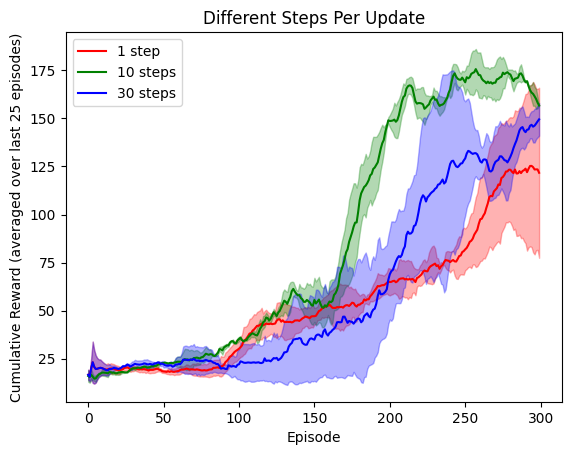

Seed=1
Training:


R25(52.76): 100%|██████████| 300/300 [00:08<00:00, 34.57it/s]  


Training finished!
Seed=2
Training:


R25(44.84): 100%|██████████| 300/300 [00:08<00:00, 37.17it/s]  


Training finished!
Seed=3
Training:


R25(32.28): 100%|██████████| 300/300 [00:06<00:00, 45.31it/s]  


Training finished!
Seed=1
Training:


R25(156.72): 100%|██████████| 300/300 [00:16<00:00, 17.94it/s] 


Training finished!
Seed=2
Training:


R25(156.72): 100%|██████████| 300/300 [00:17<00:00, 17.11it/s] 


Training finished!
Seed=3
Training:


R25(153.84): 100%|██████████| 300/300 [00:15<00:00, 18.98it/s] 


Training finished!
Seed=1
Training:


R25(144.56): 100%|██████████| 300/300 [00:20<00:00, 14.54it/s] 


Training finished!
Seed=2
Training:


R25(159.12): 100%|██████████| 300/300 [00:21<00:00, 13.82it/s] 


Training finished!
Seed=3
Training:


R25(166): 100%|██████████| 300/300 [00:21<00:00, 13.69it/s]    


Training finished!


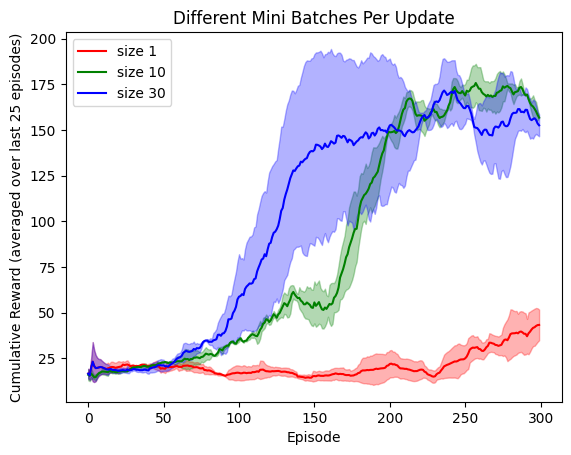

In [8]:
# Plot mean curve and (mean-std, mean+std) curve with some transparency
def plot_arrays(vars, color, label):
    mean = np.mean(vars, axis=0)
    std = np.std(vars, axis=0)
    plt.plot(range(len(mean)), mean, color=color, label=label)
    plt.fill_between(range(len(mean)), np.maximum(mean-std, 0), np.minimum(mean+std,200), color=color, alpha=0.3)

if __name__ == "__main__":

    # train with different steps per update values 
    curves = []
    steps_per_updates = [1, 10, 30]

    for steps_per_update in steps_per_updates:
        for i in range(3):
            curves += [train(SEEDS[i], steps_per_update=steps_per_update)]

    # Plot the curve for the given seeds
    plot_arrays(curves[:3], 'r', '1 step')
    plot_arrays(curves[3:5], 'g', '10 steps')
    plot_arrays(curves[5:8], 'b', '30 steps')
    plt.legend(loc='best')
    plt.title('Different Steps Per Update')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward (averaged over last 25 episodes)')
    plt.show()
    plt.close()
    
    mini_batch_sizes = [1, 10, 30]
    curves = []
    
    for mini_batch_size in mini_batch_sizes:
        for i in range(3):
            curves += [train(SEEDS[i], mini_batch_size=mini_batch_size)]

    # Plot the curve for the given seeds
    plot_arrays(curves[:3], 'r', 'size 1')
    plot_arrays(curves[3:5], 'g', 'size 10')
    plot_arrays(curves[5:8], 'b', 'size 30')
    plt.legend(loc='best')
    plt.title('Different Mini Batches Per Update')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward (averaged over last 25 episodes)')
    plt.show()
    plt.close()

## Part 3: DQN 

a) Modify and run the code for CartPole DQN to produce a graph where the
y-axis is the running average of 25 episodes for the cumulative rewards
obtained at each episode and the x-axis is the number of episodes up
to a minimum of 300 episodes. **The graph should contain 3 curves
corresponding to updating the target network every 1, 10 (default) and 30 
training step(s).** To reduce stochasticity in the results, report curves
that are the average of atleast 3 runs of the given code (with different
random seeds). Based on the results, **explain the impact of the target
network and relate the target network to value iteration** (worth 20%).

b) Modify and run the code for CartPole DQN to produce a graph where the
y-axis is the running average of 25 episodes for the cumulative rewards
obtained at each episode and the x-axis is the number of episodes up
to a minimum of 300 episodes. **The graph should contain 3 curves
corresponding to sampling mini-batches of 1, 10 (default) and 30
experience(s) from the replay buffer.** To reduce stochasticity in the results,
report curves that are the average of at least 3 runs of the given code (with
different random seeds). Based on the results, **explain the impact of the
replay buffer and explain the difference between using the replay buffer
and exact gradient descent** (worth 20%).

## 3a

The target network is an additional NN that has the same architecture as the primary NN, but is updated at a set frequency. The goal of updating it at a different frequency is to mitigate divergence. With frequent updates, the target network might diverge/become unstable. For instance, take the example of setting the steps per update (SPU) to 1. If the SPU is 1, the target network is updated at the same time the primary network is updated. This can lead to instability because frequent updates can create a feedback loop where errors in the Q-network propagate quickly into the target network. For example, adjusting the weights to try and match the ground truth at one point for one training cycle might exacerbate the error in other areas. Then on the next iteration, the model will try and fix these other errors, causing the Q-values to oscillate and diverge. Infrequent updates can lead to slow learning as infrequent updates means that improvements in the Q-network’s policy are infrequency used to update the target network. The delay in learning means that the Q-network is learning from outdated or suboptimal targets for a longer period. All these factions slow down the learning process. The impact of the update frequency can be seen in the first graph as the network using a SPU of 1 being the slowest to converge and converges to a lower cumulative rewards value than those that update less frequently. We also see that the network using a SPU of 30 not learning as quickly compare to the network using a SPU of 10. 

Using the target network in deep Q-Networks is similar to value iteration because in value iteration, we would define a new Value vector (V_new) to store the updated values and use the original value vector (V) to determine the update. Once the update is over, we set V = V_new. This way, the targets in the update stays the same. Notice that the target network serves the same purpose as V. During the update, the targets will remain constant as we do the update, and after the update is over, we change the value of the target network

## 3b

The replay buffer allows the deep Q-Network to retain some "past memories" of what it has seen. For instance, in one step, the model might update the weights to minimize the error of the Q function at a certain time step, but can introduce new errors else where. The buffer allows the model to make changes to the new point where its trying to minimize the error, but also at past data points so that the errors it introduces can be minimized as well. These past memories will also be located at different regions, meaning that any local correlations can be broken as well, allowing the training data distribution to be more stationary. This leads to more stable learning, this can be seen in the second graph as larger mini-buffer sizes alows for more stable learing and as a result, larger cumulative rewards. It also allows for fewer interactions with the environments, so it is more data efficient as well. The difference between using the replay buffer and exact gradient descent is that in exact gradient descent, it takes the gradient over the entire dataset, while the replay buffer is only at select points. 
